## Практическое задание к уроку 8 по теме "Рекуррентные нейронные сети RNN LSTM GRU".

Выяснить, какая архитектура больше подходит для задачи сентимент анализа на данных с вебинара  
1. построить свёрточную архитектуру  
2. построить различные архитектуры с RNN  
3. построить совместные архитектуры CNN -> RNN и/или (RNN -> CNN)  
4. сделать выводы что получилось лучше  

Загрузим библиотеки и датасеты:

In [1]:
%matplotlib inline

from collections import Counter
import matplotlib.pyplot as plt
from multiprocessing import cpu_count, Pool
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from string import punctuation
import torch
from torch import nn
from torchinfo import summary
from tqdm import tqdm
import urlextract

In [2]:
RANDOM_STATE = 29

In [3]:
df_train = pd.read_csv('data/train.csv', index_col='id')
df_val = pd.read_csv('data/val.csv', index_col='id')
df_train.shape, df_val.shape

((181467, 2), (22683, 2))

In [4]:
df_train.head()

,text,class
id,,
0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181467 entries, 0 to 181466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    181467 non-null  object
 1   class   181467 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


Пропущенных значений нет, посмотрим на распределение классов:

In [6]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [7]:
df_val['class'].value_counts()

1    11449
0    11234
Name: class, dtype: int64

В этот раз классы распределены почти поровну, будем использовать метрику accuracy.

Для начала обучим бейзлайн. В качестве бейзлайна возьмём модель логистической регрессии с предварительной векторизацией  
с помощью TfidfVectorizer. Обучим две таких модели: сначала будем делать токенизацию по словам, а потом по символам.  
Посмотрим, какой вариант будет лучше, так и будем дальше обрабатывать текст. Перед посимвольной токенизацией будем  
чистить датасет от пунктуации, так как этот датасет имеет лик: учитывание скобок (смайликов) даёт даже простой модели  
точность 99%. При такой точности сравнивать разные модели нет смысла, поэтому данный лик убираем.

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression(solver='sag', random_state=RANDOM_STATE)
scaler = MaxAbsScaler()

baseline = make_pipeline(vectorizer, scaler, classifier)

In [9]:
baseline.fit(df_train['text'], df_train['class']);

In [10]:
pred = baseline.predict(df_val['text'])
accuracy_score(df_val['class'], pred)

0.781025437552352

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), analyzer='char', preprocessor=lambda x: re.sub(f'[{punctuation}]', ' ', x))
baseline = make_pipeline(vectorizer, scaler, classifier)

baseline.fit(df_train['text'], df_train['class'])
pred = baseline.predict(df_val['text'])
accuracy_score(df_val['class'], pred)

/home/shkin/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7878587488427456

Модель с посимвольной токенизацией оказалась лучше, поэтому далее будем токенизировать символы. Также это более интересно,
так как ранее токенизацию делал только по словам.

In [12]:
url_extractor = urlextract.URLExtract()

In [13]:
def preprocess_text(text):
    
    # Заменяем ссылки на тэг
    urls = url_extractor.find_urls(text, only_unique=True)
    for url in urls:
        text = text.replace(url, ' url ')
    
    # Убираем характерные для твиттера обращения с никами пользователей,  
    # не хотим, чтобы модели переобучались на чьи-то ники
    text = re.sub('@\w+', '', text)
    
    # Убираем символы переноса строки
    text = re.sub(r'\n', '', text)
    
    # Убираем пунктуацию, приводим к нижнему регистру
    text = re.sub(f'[{punctuation}]', '', text)
    text = text.lower()
    
    # Делаем посимвольную токенизацию
    text = list(text)
    
    return ' '.join(text)

Обрабатываем текст:

In [14]:
with Pool(cpu_count()) as p:
    df_train['processed'] = tqdm(p.imap(preprocess_text, df_train['text']), total=len(df_train))
    df_val['processed'] = tqdm(p.imap(preprocess_text, df_val['text']), total=len(df_val))

100%|██████████████████████████████████| 22683/22683 [00:01<00:00, 15718.10it/s]


In [15]:
df_train['processed'].sample(10)

id
89543       з а б и т ь   р у к а в   и   п о с т а в и ...
84243     л е р а п о д т я г и в а й   х и м и ю   в о ...
105255    м е н я   с е г о д н я   ж е с т о к о   р а ...
36974       н е   н о р м а л ь н ы й   з а к а з     к ...
97048     к а к о й т о   щ е д р ы й   п а р е н ь   в ...
83620     у   а н д р э   т р у х а н ы   в   п е р д а ...
56130       п о н к р а ш а   з а р е т в и т е л   с   ...
35645     н е   н у   т о л ь к о   я   т а к   м о г л ...
126905      д о б р о й   п я т н и ц ы   в с е м   ч и ...
12141       у ф ф ф   м а с т е р   ч т о   н а д о   о ...
Name: processed, dtype: object

Для определения фиксированной длины последовательности посмотрим на распределение длин:

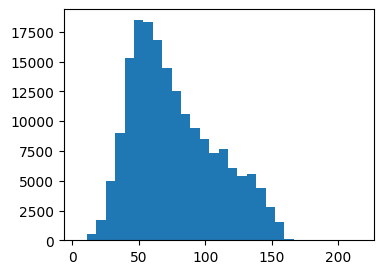

In [16]:
plt.figure(figsize=(4, 3))
plt.hist(df_train['processed'].apply(lambda x: len(x.split(' '))), bins=30);

Примем длину последовательности:

In [17]:
MAX_LEN = 170

Создадим словарь:

In [18]:
corpus = ' '.join(df_train['processed'])

In [19]:
dist = Counter(corpus.split(' '))

In [20]:
vocabulary = {w: i for i, w in dict(enumerate(dist.keys(), 1)).items()}

In [21]:
len(vocabulary)

317

Небольшая длина словаря, так как токенизировали символы.

In [22]:
VOCAB_SIZE = len(vocabulary) + 1

Обработаем все последовательности для соответствия фиксированной длине. Обрежем или добавим паддинг, где нужно:

In [23]:
def text_to_seq(text):
    seq = []
    for token in text.split(' '):
        if token in vocabulary:
            seq.append(vocabulary[token])
    padding = [0] * (MAX_LEN - len(seq))
    return seq[:MAX_LEN] + padding

In [24]:
X_train = np.array([text_to_seq(text) for text in df_train['processed']])
X_val = np.array([text_to_seq(text) for text in df_val['processed']])

In [25]:
X_train

array([[ 1,  1,  2, ...,  0,  0,  0],
       [18, 19,  1, ...,  0,  0,  0],
       [18, 19,  1, ...,  0,  0,  0],
       ...,
       [ 1,  1, 11, ...,  0,  0,  0],
       [ 1,  1,  4, ...,  0,  0,  0],
       [ 1,  1, 10, ...,  0,  0,  0]])

Напишем класс датасета:

In [26]:
class DataWrapper(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Обернём датасеты в даталоадеры:

In [27]:
BATCH_SIZE = 256

In [28]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = DataWrapper(X_train, df_train['class'].values)
val_dataset = DataWrapper(X_val, df_val['class'].values)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         drop_last=True)

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Будем обучать 4 варианта сетей: свёрточную, рекуррентную, свёрточную + рекуррентную, а также рекуррентную + свёрточную.  
Архитектура сетей, за исключением указанных выше различий, максимально приближена друг к другу, чтобы исключить влияние  
других факторов на результат.  То есть размерность эмбеддингов, количество фильтров свёрточной сети, а также размерность вектора скрытого состояния рекуррентной сети везде были одинаковы, как и количество нейронов полносвязной части сетей. Коэффициент обучения и количество эпох подбирались индивидуально из-за различий архитектур: не хотелось, чтобы сеть показала плохой результат только из-за неправильно выставленных гиперпараметров. Количество эпох настраивалось  
с шагом 5, а коэффициент обучения - с шагом 0,005. Перед нами не ставилась задача показать хорошую точность моделей, и,  
забегая вперёд, только одна сеть смогла обойти бейзлайн. Задачей было сравнить эти архитектуры. Чтобы показать хороший результат, нужно усложнить модели, возможно, добавить слоёв. Например, сделать для свёрточной части сетей несколько различных свёрток (с kernel_size 2, 3, 4 и т.д.) и застекать их. Для рекуррентных сетей попробовать варианты двухслойной сети или двунаправленной сети. Это всё будет дольше обучаться, а у нас 4 модели.

### 1. CNN

In [30]:
class ConvNet(nn.Module):
    def __init__(self, embed_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.conv = nn.Sequential(nn.Conv1d(embed_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.MaxPool1d(MAX_LEN // conv_stride - kernel_size + 1),
                                  nn.ReLU())
        
        self.fc1 = nn.Sequential(nn.Linear(conv_filters, conv_filters // 2),
                                 nn.ReLU())
        
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_filters // 2, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        x = x.permute(0, 2 ,1)
        x = torch.squeeze(self.conv(x))
        x = self.fc1(x)
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [31]:
summary(ConvNet())

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Embedding: 1-1                         40,704
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       49,280
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
├─Dropout: 1-4                           --
├─Dropout: 1-5                           --
├─Linear: 1-6                            65
Total params: 98,305
Trainable params: 98,305
Non-trainable params: 0

Напишем функцию для обучения сетей, одну для всех:

In [32]:
def train_nn(net, epochs=5, lr=1e-3):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True

    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        train_losses = np.array([])
        test_losses = np.array([])
        train_metrics = np.array([])
        test_metrics = np.array([])

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            train_losses = np.append(train_losses, loss.item())

            net.eval()
            outputs = net(inputs)
            train_metrics = np.append(train_metrics, accuracy_score(labels.cpu(), torch.squeeze(outputs > 0.5).cpu()))

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Train Loss: {train_losses.mean():.3f}. ' \
              f'Train Accuracy: {train_metrics.mean():.3f}', end='. ')


        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels.float().view(-1, 1))
                test_losses = np.append(test_losses, loss.item())
                test_metrics = np.append(test_metrics, accuracy_score(labels.cpu(), torch.squeeze(outputs > 0.5).cpu()))
                
        print(f'Test loss: {test_losses.mean():.3f}. Test Accuracy: {test_metrics.mean():.3f}')

    print('Training is finished!')

Обучим сеть:

In [33]:
conv_model = ConvNet(embed_dim=128, conv_filters=128, kernel_size=5, conv_stride=1)
train_nn(conv_model, epochs=40, lr=1e-3)

Epoch [1/40]. Train Loss: 0.581. Train Accuracy: 0.698. Test loss: 0.535. Test Accuracy: 0.717
Epoch [2/40]. Train Loss: 0.535. Train Accuracy: 0.736. Test loss: 0.519. Test Accuracy: 0.724
Epoch [3/40]. Train Loss: 0.519. Train Accuracy: 0.746. Test loss: 0.509. Test Accuracy: 0.735
Epoch [4/40]. Train Loss: 0.508. Train Accuracy: 0.755. Test loss: 0.500. Test Accuracy: 0.747
Epoch [5/40]. Train Loss: 0.501. Train Accuracy: 0.761. Test loss: 0.496. Test Accuracy: 0.751
Epoch [6/40]. Train Loss: 0.494. Train Accuracy: 0.766. Test loss: 0.491. Test Accuracy: 0.753
Epoch [7/40]. Train Loss: 0.488. Train Accuracy: 0.770. Test loss: 0.489. Test Accuracy: 0.755
Epoch [8/40]. Train Loss: 0.485. Train Accuracy: 0.772. Test loss: 0.488. Test Accuracy: 0.755
Epoch [9/40]. Train Loss: 0.480. Train Accuracy: 0.776. Test loss: 0.486. Test Accuracy: 0.753
Epoch [10/40]. Train Loss: 0.476. Train Accuracy: 0.779. Test loss: 0.484. Test Accuracy: 0.757
Epoch [11/40]. Train Loss: 0.473. Train Accuracy:

В целом, свёрточная модель показала точность чуть ниже 77%.

### 2. RNN

In [34]:
class RnnNet(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        
        self.fc1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                 nn.ReLU())
        
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        
        # Берём только вектор последнего скрытого состояния,  
        # он выполнит роль своеобразного пулинга перед полносвязной сетью
        _, x = self.gru(x) 
        
        x = self.fc1(torch.squeeze(x))
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [35]:
summary(RnnNet())

Layer (type:depth-idx)                   Param #
RnnNet                                   --
├─Embedding: 1-1                         40,704
├─GRU: 1-2                               99,072
├─Sequential: 1-3                        --
│    └─Linear: 2-1                       8,256
│    └─ReLU: 2-2                         --
├─Linear: 1-4                            65
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
Total params: 148,097
Trainable params: 148,097
Non-trainable params: 0

In [36]:
rnn_model = RnnNet(embed_dim=128, hidden_dim=128)
train_nn(rnn_model, epochs=40, lr=5e-4)

Epoch [1/40]. Train Loss: 0.693. Train Accuracy: 0.506. Test loss: 0.693. Test Accuracy: 0.504
Epoch [2/40]. Train Loss: 0.693. Train Accuracy: 0.507. Test loss: 0.693. Test Accuracy: 0.505
Epoch [3/40]. Train Loss: 0.693. Train Accuracy: 0.508. Test loss: 0.693. Test Accuracy: 0.505
Epoch [4/40]. Train Loss: 0.693. Train Accuracy: 0.509. Test loss: 0.693. Test Accuracy: 0.508
Epoch [5/40]. Train Loss: 0.693. Train Accuracy: 0.511. Test loss: 0.693. Test Accuracy: 0.508
Epoch [6/40]. Train Loss: 0.616. Train Accuracy: 0.644. Test loss: 0.552. Test Accuracy: 0.704
Epoch [7/40]. Train Loss: 0.541. Train Accuracy: 0.723. Test loss: 0.523. Test Accuracy: 0.726
Epoch [8/40]. Train Loss: 0.520. Train Accuracy: 0.738. Test loss: 0.511. Test Accuracy: 0.733
Epoch [9/40]. Train Loss: 0.508. Train Accuracy: 0.746. Test loss: 0.500. Test Accuracy: 0.742
Epoch [10/40]. Train Loss: 0.499. Train Accuracy: 0.754. Test loss: 0.510. Test Accuracy: 0.736
Epoch [11/40]. Train Loss: 0.490. Train Accuracy:

Точность рекуррентной модели чуть ниже 78%.

### 3. CNN -> RNN

Здесь, в отличие от просто CNN сети, мы не будем использовать пулинг после свёртки, так как нам нужно всё получившееся пространство, которое будет эмбеддингом для рекуррентной сети:

In [37]:
class ConvRnnNet(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.conv = nn.Sequential(nn.Conv1d(embed_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.ReLU())
        
        self.gru = nn.GRU(conv_filters, hidden_dim, batch_first=True)
        
        self.fc1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2),
                                 nn.ReLU())
        
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        x = x.permute(0, 2 ,1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        _, x = self.gru(x)
        x = self.fc1(torch.squeeze(x))
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [38]:
summary(ConvRnnNet())

Layer (type:depth-idx)                   Param #
ConvRnnNet                               --
├─Embedding: 1-1                         40,704
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       49,280
│    └─ReLU: 2-2                         --
├─GRU: 1-3                               99,072
├─Sequential: 1-4                        --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
├─Linear: 1-5                            65
├─Dropout: 1-6                           --
├─Dropout: 1-7                           --
Total params: 197,377
Trainable params: 197,377
Non-trainable params: 0

In [39]:
conv_rnn_model = ConvRnnNet(kernel_size=5)
train_nn(conv_rnn_model, epochs=30, lr=5e-4)

Epoch [1/30]. Train Loss: 0.693. Train Accuracy: 0.507. Test loss: 0.693. Test Accuracy: 0.508
Epoch [2/30]. Train Loss: 0.693. Train Accuracy: 0.510. Test loss: 0.693. Test Accuracy: 0.509
Epoch [3/30]. Train Loss: 0.666. Train Accuracy: 0.538. Test loss: 0.660. Test Accuracy: 0.544
Epoch [4/30]. Train Loss: 0.659. Train Accuracy: 0.547. Test loss: 0.619. Test Accuracy: 0.642
Epoch [5/30]. Train Loss: 0.583. Train Accuracy: 0.682. Test loss: 0.538. Test Accuracy: 0.716
Epoch [6/30]. Train Loss: 0.520. Train Accuracy: 0.740. Test loss: 0.503. Test Accuracy: 0.744
Epoch [7/30]. Train Loss: 0.491. Train Accuracy: 0.762. Test loss: 0.479. Test Accuracy: 0.761
Epoch [8/30]. Train Loss: 0.474. Train Accuracy: 0.775. Test loss: 0.473. Test Accuracy: 0.768
Epoch [9/30]. Train Loss: 0.461. Train Accuracy: 0.784. Test loss: 0.462. Test Accuracy: 0.772
Epoch [10/30]. Train Loss: 0.451. Train Accuracy: 0.792. Test loss: 0.458. Test Accuracy: 0.776
Epoch [11/30]. Train Loss: 0.442. Train Accuracy:

Данная связка показала точность 79%. Эта модель обошла наш бейзлайн.

### 4. RNN -> CNN

Здесь уже выходы рекуррентной сети будут эмбеддингами свёрточной сети. Поэтому из рекуррентной сети берём не только вектор последнего скрытого состояния, а все вектора скрытого состояния, на каждом временном отрезке t:

In [40]:
class RnnConvNet(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=128, conv_filters=128, kernel_size=3, conv_stride=1):
        torch.random.manual_seed(RANDOM_STATE)
        super().__init__()
        
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=0)
        
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        
        self.conv = nn.Sequential(nn.Conv1d(hidden_dim, conv_filters, kernel_size=kernel_size, stride=conv_stride),
                                  nn.MaxPool1d(MAX_LEN // conv_stride - kernel_size + 1),
                                  nn.ReLU())
        
        self.fc1 = nn.Sequential(nn.Linear(conv_filters, conv_filters // 2),
                                 nn.ReLU())
        
        self.dp02 = nn.Dropout(0.2)
        self.dp05 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_filters // 2, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dp02(x)
        
        # Берём все векторы h
        x, _ = self.gru(x)
        
        x = x.permute(0, 2 ,1)
        x = torch.squeeze(self.conv(x))
        x = self.fc1(x)
        x = self.dp05(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [41]:
summary(RnnConvNet())

Layer (type:depth-idx)                   Param #
RnnConvNet                               --
├─Embedding: 1-1                         40,704
├─GRU: 1-2                               99,072
├─Sequential: 1-3                        --
│    └─Conv1d: 2-1                       49,280
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-4                        --
│    └─Linear: 2-4                       8,256
│    └─ReLU: 2-5                         --
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─Linear: 1-7                            65
Total params: 197,377
Trainable params: 197,377
Non-trainable params: 0

In [42]:
rnn_conv_model = RnnConvNet(kernel_size=5)
train_nn(rnn_conv_model, epochs=15, lr=5e-4)

Epoch [1/15]. Train Loss: 0.579. Train Accuracy: 0.693. Test loss: 0.532. Test Accuracy: 0.722
Epoch [2/15]. Train Loss: 0.519. Train Accuracy: 0.743. Test loss: 0.514. Test Accuracy: 0.733
Epoch [3/15]. Train Loss: 0.497. Train Accuracy: 0.761. Test loss: 0.493. Test Accuracy: 0.750
Epoch [4/15]. Train Loss: 0.479. Train Accuracy: 0.774. Test loss: 0.487. Test Accuracy: 0.755
Epoch [5/15]. Train Loss: 0.467. Train Accuracy: 0.782. Test loss: 0.476. Test Accuracy: 0.767
Epoch [6/15]. Train Loss: 0.453. Train Accuracy: 0.790. Test loss: 0.479. Test Accuracy: 0.761
Epoch [7/15]. Train Loss: 0.444. Train Accuracy: 0.797. Test loss: 0.470. Test Accuracy: 0.772
Epoch [8/15]. Train Loss: 0.435. Train Accuracy: 0.803. Test loss: 0.462. Test Accuracy: 0.776
Epoch [9/15]. Train Loss: 0.426. Train Accuracy: 0.809. Test loss: 0.458. Test Accuracy: 0.774
Epoch [10/15]. Train Loss: 0.419. Train Accuracy: 0.814. Test loss: 0.458. Test Accuracy: 0.778
Epoch [11/15]. Train Loss: 0.408. Train Accuracy:

Данная связка показала чуть более 78%. Она обогнала бейзлайн, который делал токенизацию по словам, но не превзошла бейзлайн с токенизацией по символам.

<ins>Вывод:</ins>  
Наименее результативной моделью оказалась свёрточная сеть, а связки моделей показали лучший результат. Лучшая связка CNN -> RNN даже обошла бейзлайн.